##  Sentinel-3 SLSTR tiling

### Service Definition

In [1]:
service = dict([('title', 'Sentinel-3 SLSTR Level-2 reprojection and tiling'),
                ('abstract', 'This service takes as input a Sentinel-3 SLSTR Level 2 (SL_2_LST____) product on DESCENDING pass and does the reprojection and tiling'),
                ('identifier', 'ewf-wfp-03-01-02')])

### Parameter Definition 

### Runtime parameter definition

**Input reference**

The input identifier is the catalogue entry URL (a.k.a. self value).

In [2]:
input_reference = dict([('identifier', 'input_reference'),
                        ('title', 'Sentinel-3 SLSTR Level-2 (SL_2_LST____ descending pass)'),
                        ('abstract', 'This service takes as input a Sentinel-3 SLSTR Level 2 (SL_2_LST____) product on DESCENDING pass'),
                        ('value', 'https://catalog.terradue.com/sentinel3/search?format=json&uid=S3A_SL_2_LST____20200422T063257_20200422T081356_20200423T193710_6059_057_234______LN2_O_NT_004'),
                        ('stac:collection', 'input_reference'),
                        ('stac:href', 'catalog.json'),
                        ('max_occurs', '16')])

In [3]:
tiling_level = dict([('identifier', 'tiling_level'),
                ('value', '5'),
                ('title', 'Tiling level'),
                ('abstract', 'Tiling level'),
                ('max_occurs', '1')])


In [4]:
aoi = dict([('identifier', 'aoi'),
                ('value', 'POLYGON ((26.016000747680664 -2.1089999675750732, 59.0629997253418 -2.1089999675750732, 59.0629997253418 12.211000442504883, 26.016000747680664 12.211000442504883, 26.016000747680664 -2.1089999675750732, 26.016000747680664 -2.1089999675750732))'),
                ('title', 'Area of Interest'),
                ('abstract', 'Area of Interest'),
                ('max_occurs', '1')])


**Data path**

This path defines where the data is staged-in. 

In [5]:
data_path = '/workspace/'

In [6]:
input_catalog = '/workspace/catalog.json'

### Workflow

#### Import the packages

In [7]:
import os
import sys
os.environ['PREFIX'] = '/opt/anaconda/envs/env_s3/'
os.environ['GPT_BIN'] = os.path.join(os.environ['PREFIX'], 'snap/bin/gpt')
#os.environ['_JAVA_OPTIONS'] = '-Xms41g -Xmx41g'

sys.path.append('.')
import gdal
from helpers import *
from shapely.wkt import loads
from shapely.geometry import box
from shapely.geometry import shape
import shutil
from pystac import Catalog, Collection, Item, MediaType, Asset, CatalogType

from tiling import s3_tiles
import time
import glob

gdal.UseExceptions()

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
cat = Catalog.from_file(input_catalog)

if cat is None:
    raise ValueError()

In [10]:
collection = next(cat.get_children())

In [11]:
item = next(collection.get_items())

In [12]:
item.properties['eop:orbitDirection']

'DESCENDING'

In [13]:
if item.properties['eop:orbitDirection'] != 'DESCENDING':
    ciop.log('ERROR','Product cannot be used as input')
    raise Exception('Use products with descending orbit direction')

In [14]:
s3_wkt = shape(item.geometry).wkt

In [15]:
aoi_wkt = loads(aoi['value']).wkt

### Import Sentinel-3 SLSTR product

In [16]:
operators = ['Read',
             'Subset',
             'Reproject',
             'Write']

In [17]:
read = dict()

s3_path = item.assets['metadata'].get_absolute_href()

read['file'] =  s3_path
read['formatName'] = 'Sen3'

subset = dict()
subset['geoRegion'] = aoi_wkt
subset['copyMetadata'] = 'true'
subset['fullSwath'] = 'true'

reproject = dict()
reproject['crs'] = 'EPSG:4326'

write = dict()
write['file'] = 's3_slstr'

In [18]:
snap_graph(os.environ['GPT_BIN'],
           operators,
           Subset=subset,
           Read=read, 
           Reproject=reproject,
           Write=write)

0

In [19]:
def s3_to_tile(input_tif, item, tile):
    
    translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-co TILED=YES -co COPY_SRC_OVERVIEWS=YES -co COMPRESS=LZW"))
        
    x_min, y_min, x_max, y_max = tile.tile.buffer(0.05).bounds

    output_tile_name = '{}_L{}_C{}_R{}'.format(item.id,
                                                    tile.level,
                                                    tile.col,
                                                    tile.row)


    gdal.Translate('tmp_{}.tif'.format(output_tile_name),
                   input_tif,
                   projWin=[x_min, y_max, x_max, y_min],
                   projWinSRS='EPSG:4326')

    ds = gdal.Open('tmp_{}.tif'.format(output_tile_name),
                   gdal.OF_READONLY)

    gdal.SetConfigOption('COMPRESS_OVERVIEW', 'DEFLATE')
    ds.BuildOverviews('NEAREST', [2,4,8,16,32])
    ds = None

    ds = gdal.Open('tmp_{}.tif'.format(output_tile_name))
    ds = gdal.Translate('{}.tif'.format(output_tile_name), ds, options=translate_options)
    ds = None

    band_names = ['LST', 'NDVI', 'Land mask', 'Cloud mask']

    ds = gdal.Open('{}.tif'.format(output_tile_name), gdal.GA_Update)

    # update extended area to -10000 instead of 0 as gdal.trasnlate does
    ndvi_data = ds.GetRasterBand(1).ReadAsArray()
    land_data = ds.GetRasterBand(2).ReadAsArray()
    cloud_data = ds.GetRasterBand(3).ReadAsArray()
    
    updated_ndvi_data = np.full(ndvi_data.shape, -10000)
    
    updated_ndvi_data = np.where((land_data == 1) | (cloud_data == 1), 
                                 ndvi_data, -10000)
    
    ds.GetRasterBand(1).WriteArray(updated_ndvi_data)
    
    ds.FlushCache()
    
    ds = None
    
    ds = gdal.Open('{}.tif'.format(output_tile_name), gdal.GA_Update)
    
    for index in range(ds.RasterCount):

        srcband = ds.GetRasterBand(index+1)

        srcband.SetDescription(band_names[index])

        if index == 0:
            
            srcband.SetNoDataValue(-10000)
    
    ds.FlushCache()

    ds = None
    
    with open(output_tile_name + '.properties', 'w') as file:

        file.write('title=Tile L:{1} C:{2} R:{3} {0}\n'.format(item.id,
                                                              tile.level, 
                                                              tile.col, 
                                                              tile.row))
        
        date='{}/{}'.format(item.datetime.strftime('%Y-%m-%dT%H:%M:%SZ'), 
                                         item.datetime.strftime('%Y-%m-%dT%H:%M:%SZ'))
        
        file.write('date={}\n'.format(date))
        
        file.write('geometry={0}'.format(tile.tile.buffer(0.05).wkt))


    for f in ['tmp_{}.tif'.format(output_tile_name), 'tmp_{}.tif.ovr'.format(output_tile_name)]:

        if os.path.exists(f):

            os.remove(f)
    
    return True
    

### Tiling

In [20]:
bands = [os.path.join('s3_slstr.data', '{}.img'.format(band)) for band in ['LST', 'NDVI', 'cloud_in', 'confidence_in']]
        
s3_data = read_s3(bands)
        

In [21]:
ds = gdal.Open(bands[0])

geo_transform = ds.GetGeoTransform()
projection_ref = ds.GetProjectionRef()
    

In [22]:
lst = s3_data[:,:,0]
ndvi = s3_data[:,:,1]
cloud = s3_data[:,:,2]
confidence = s3_data[:,:,3]

In [23]:
mask = get_slstr_confidence_mask('land', confidence)

In [24]:
cloud_mask =  get_slstr_mask('gross_cloud', cloud)

In [25]:
output_name = 'temp.tif'

In [26]:
driver = gdal.GetDriverByName('GTiff')

output = driver.Create(output_name, 
                       lst.shape[1], 
                       lst.shape[0], 
                       4, 
                       gdal.GDT_Float32)

output.SetGeoTransform(geo_transform)
output.SetProjection(projection_ref)
output.GetRasterBand(1).WriteArray(lst)
output.GetRasterBand(2).WriteArray(ndvi)
output.GetRasterBand(3).WriteArray(mask)
output.GetRasterBand(4).WriteArray(cloud_mask)

output.FlushCache()

output = None

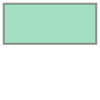

In [27]:
loads(aoi['value'])

In [28]:

#tiles = s3_tiles(shape(item.geometry), int(tiling_level['value']))
tiles = s3_tiles(loads(aoi['value']), int(tiling_level['value']))

In [29]:
tiles

,col,row,level,s3_tile,tile
0,36,15,5,"POLYGON ((26.01600 -2.10900, 26.01600 0.00000,...","POLYGON ((28.12500 -5.62500, 28.12500 0.00000,..."
1,36,16,5,"POLYGON ((26.01600 0.00000, 26.01600 5.62500, ...","POLYGON ((28.12500 0.00000, 28.12500 5.62500, ..."
2,36,17,5,"POLYGON ((26.01600 5.62500, 26.01600 11.25000,...","POLYGON ((28.12500 5.62500, 28.12500 11.25000,..."
3,36,18,5,"POLYGON ((26.01600 11.25000, 26.01600 12.21100...","POLYGON ((28.12500 11.25000, 28.12500 16.87500..."
4,37,15,5,"POLYGON ((33.75000 -2.10900, 28.12500 -2.10900...","POLYGON ((33.75000 -5.62500, 33.75000 0.00000,..."
5,37,16,5,"POLYGON ((33.75000 0.00000, 28.12500 0.00000, ...","POLYGON ((33.75000 0.00000, 33.75000 5.62500, ..."
6,37,17,5,"POLYGON ((33.75000 5.62500, 28.12500 5.62500, ...","POLYGON ((33.75000 5.62500, 33.75000 11.25000,..."
7,37,18,5,"POLYGON ((28.12500 12.21100, 33.75000 12.21100...","POLYGON ((33.75000 11.25000, 33.75000 16.87500..."
8,38,15,5,"POLYGON ((39.37500 -2.10900, 33.75000 -2.10900...","POLYGON ((39.37500 -5.62500, 39.37500 0.00000,..."
9,38,16,5,"POLYGON ((39.37500 0.00000, 33.75000 0.00000, ...","POLYGON ((39.37500 0.00000, 39.37500 5.62500, ..."


In [30]:
for index, tile in tiles.iterrows():
    
    logging.info('Tile L{} C{} R{}'.format(tile.level,
                                       tile.col,
                                       tile.row))


    s3_to_tile(output_name, item, tile)

In [31]:
logging.info('Clean-up') 
os.remove(output_name)

shutil.rmtree('s3_slstr.data')
os.remove('s3_slstr.dim')

time.sleep(45)

for f in glob.glob('./*.tif.aux.xml'):

    os.remove(f)


### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.